# Collaboration and Competition

---

This notebook runs John's solution for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.  It uses the Unity ML-Agents environment to train two cooperative agents to play a tennis-like game.

**Need more description here - refer to readme?**






...


This code depends upon a custom Unity environment provided by the Udacity staff that embodies the variation on tennis.  It will open a separate Unity window for visualizing the environment as the agents train or play.


## Define how we will use this notebook - JOHN FIX THIS!!!!

In the next cell, set the appropriate values of a couple control variables:
- **EXPLORE** determines whether the notebook does exploratory training or inference demonstration.
    - **True** runs a hyperparameter exploration loop to generate many training runs with a random search algorithm.  To use this well, you should study that cell and specify the ranges of hyperparameters to be explored.
    - **False** runs a few inference episodes of a pretrained model and opens a visualization window to watch it play.
- **config_name:** the name of a model configuration & run to be loaded from a checkpoint to begin the exercise.  
    - If EXPLORE = True, this is optional, and tells the training loop to start from this pre-trained model and continue refining it; if the value is _None_ then the training starts from a randomly initialized model.
    - If EXPLORE = False, then this must reflect the name of a legitimate config/run (e.g. "M37.01").
- **checkpoint_episode:** if a checkpoint is being used to start the exercise, then this number reflects what episode that checkpoint was captured from.  The checkpoint_name and checkpoint_episode together are required to completely identify the checkpoint file.


In [1]:
EXPLORE            = True
config_name        = None # Must be None if not using!
run_number         = 0
checkpoint_episode = 2

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from train import train
from maddpg import Maddpg

%matplotlib inline

initial_episode = checkpoint_episode
checkpoint_path = "checkpoint/{}/".format(config_name)
tag = "{}.{:02d}".format(config_name, run_number)

if EXPLORE:
    turn_off_graphics = True
    initial_episode = 0
    unity_train_mode = True
    if config_name != None:
        initial_episode = checkpoint_episode
else:
    turn_off_graphics = False
    unity_train_mode = False

# create a new Unity environment
# it needs to be done once, outside any loop, as closing an environment then restarting causes
# a Unity exception about the handle no longer being active.
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", seed=0, 
                       no_graphics=turn_off_graphics)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]                       
env_info = env.reset(train_mode=unity_train_mode)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Train the agents

The next cells will invoke the training program to create the agents.  All of the real code is in Python flat files in this project directory.

In [3]:
import numpy as np

class RandomSampler():
    
    def __init__(self, vars):
        """Accepts definition of the set of variables to be sampled.
            
            Params:
                vars (list of lists): each item is a list containing:
                                        item 0 - either 'discrete', 'continuous-int' or 'continuous-float'
                                        items 1-N depend on the value of item 0:
                                        if discrete, then these are the set of values to be chosen from
                                        if continuous then these are the min & max bounds of the range
        """
        
        self.vars = vars
        
        self.rng = np.random.default_rng()
    
    
    def sample(self):
        """Draws a random sample of all variables at its disposal.
        
            Returns a list of values in the order of definition.
        """

        rtn = []
        for v in self.vars:
            if v[0] == "discrete":
                choice = self.rng.integers(low=1, high=len(v), size=1)[0]
                rtn.append(v[choice])
                
            elif v[0] == "continuous-int":
                choice = self.rng.integers(low=v[1], high=v[2], size=1)[0]
                rtn.append(choice)
                
            elif v[0] == "continuous-float":
                choice = self.rng.random() * (v[2]-v[1]) + v[1]
                rtn.append(choice)
            
            else:
                print("///// RandomSampler error:  unknown type ", v[0])
            
        return rtn
                
vars = [["discrete", 88, 66, 11, 22, 33, 44, 99, 101, 77],
        ["discrete", 500], #1-item list
        ["continuous-int", 43, 44], #1-item range
        ["continuous-int", 0, 10],
        ["continuous-float", 0.0, 1.0],
        ["continuous-float", -3.3, 0.0],
        ["continuous-float", -1.0, 6.4],
       ]
rs = RandomSampler(vars)

for i in range(3):
    out = rs.sample()
    print("\n", i, "\n", out)



 0 
 [33, 500, 43, 5, 0.47859854191681983, -0.8729684231316783, 3.216798364512516]

 1 
 [99, 500, 43, 3, 0.33557128469106057, -0.10537008359112043, -0.2473513749465578]

 2 
 [101, 500, 43, 4, 0.381874512222778, -2.3007667558389944, -0.6822364877528551]


Ready to train M44 over 30 training sets for 12001 episodes each, with fixed params:
    Max episodes   =  12001
    Weight decay   =  1e-05
    Gamma          =  0.99
    LR anneal freq =  10000
    LR anneal mult =  1.0
    Buf prime size =  5000

///// Beginning training set  M44.00  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999554
      Noise scale      = 0.020
      LR actor         = 0.0000802
      LR critic        = 0.0000516
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00630
      Seed             =  44939
Priming the replay buffer........................!

174	Running avg/max: 0.004/0.100,  mem:   7574/     4 ( 0.1%), avg 119.0 eps/min   
* noise mult = 0.1
588	Running avg/max: 0.000/0.000,  mem:  13513/     7 ( 0.1%), avg 121.2 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19363/     7 ( 0.0%), avg 122.6 eps/min;  

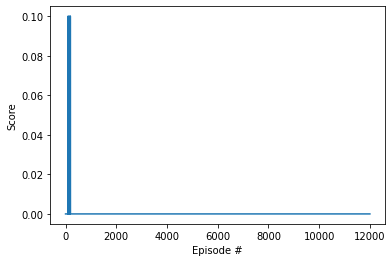

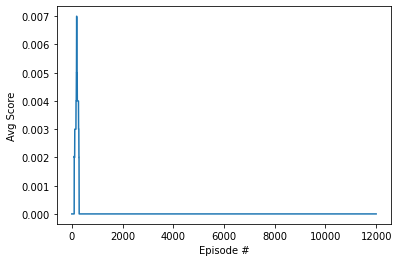


///// Beginning training set  M44.01  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999256
      Noise scale      = 0.100
      LR actor         = 0.0000755
      LR critic        = 0.0000451
      Learning every      80  time steps
      Learn iterations =  2
      Tau              = 0.00610
      Seed             =  44939
Priming the replay buffer.........................!

93	Running avg/max: 0.005/0.100,  mem:   6547/     6 ( 0.1%), avg 668.9 eps/min   
* noise mult = 0.1
343	Running avg/max: 0.000/0.000,  mem:  10097/     6 ( 0.1%), avg 739.2 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19427/     6 ( 0.0%), avg 755.9 eps/min;  0.2 hr rem   
2000	Average score:   0.000,        mem:  33627/     6 ( 0.0%), avg 762.6 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  47827/     6 ( 0.0%), avg 761.5 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        me

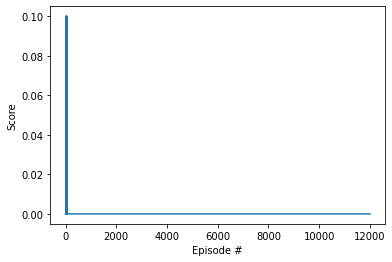

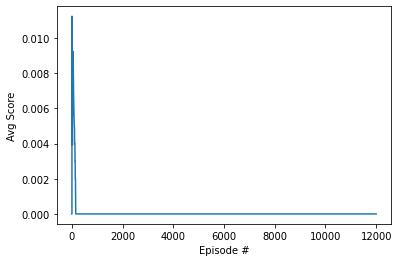


///// Beginning training set  M44.02  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999782
      Noise scale      = 1.000
      LR actor         = 0.0000738
      LR critic        = 0.0000598
      Learning every      20  time steps
      Learn iterations =  2
      Tau              = 0.00243
      Seed             =  44939
Priming the replay buffer.........................!

368	Running avg/max: 0.000/0.000,  mem:   5802/     3 ( 0.1%), avg 329.7 eps/min   
* noise mult = 0.1
1000	Average score:   0.000,        mem:   7168/     3 ( 0.0%), avg 328.2 eps/min;  0.6 hr rem   
1222	Running avg/max: 0.000/0.000,  mem:   7625/     3 ( 0.0%), avg 327.7 eps/min   
* noise mult = 0.0005
2000	Average score:   0.001,        mem:   9293/     4 ( 0.0%), avg 327.6 eps/min;  0.5 hr rem   
3000	Average score:   0.063,        mem:  11932/   125 ( 1.0%), avg 309.2 eps/min;  0.5 hr rem   
4000	Average score:   0.000,        

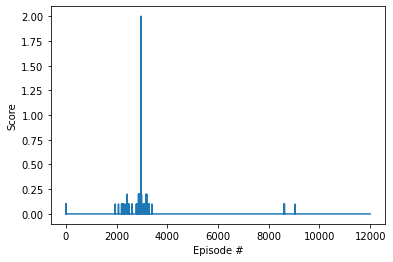

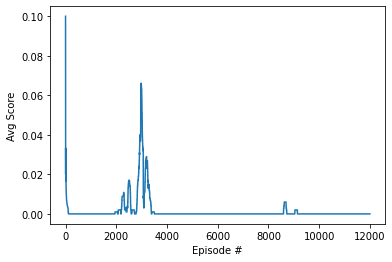


///// Beginning training set  M44.03  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999590
      Noise scale      = 0.020
      LR actor         = 0.0001469
      LR critic        = 0.0000717
      Learning every      2  time steps
      Learn iterations =  2
      Tau              = 0.00705
      Seed             =  44939
Priming the replay buffer.........................!

196	Running avg/max: 0.000/0.000,  mem:   5413/     0 ( 0.0%), avg 61.3 eps/min   
* noise mult = 0.1
635	Running avg/max: 0.000/0.000,  mem:   6409/    13 ( 0.2%), avg 59.6 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7183/    13 ( 0.2%), avg 60.7 eps/min;  3.0 hr rem   
2000	Average score:   0.000,        mem:   9325/    18 ( 0.2%), avg 61.5 eps/min;  2.7 hr rem   
3000	Average score:   0.000,        mem:  11493/    18 ( 0.2%), avg 62.1 eps/min;  2.4 hr rem   
4000	Average score:   0.000,        mem:  1

KeyboardInterrupt: 

In [4]:
# This cell will explore several combinations of hyperparams by training all of them
# Use a random search for the hyperparams

TIME_STEPS         = 600
SAVE_ANALYSIS      = False
MODEL_DISPLAY_STEP = 0 #200k is approx 10k episodes at bad_step_prob = 0.01

if EXPLORE:
    
    # fixed for the session:
    RUN_PREFIX        = "M44"
    EPISODES          = 12001
    NUM_RUNS          = 30
    BUFFER_PRIME_SIZE = 5000
    WEIGHT_DECAY      = 1.0e-5 #was 1.0e-5
    GAMMA             = 0.99
    LR_ANNEAL_FREQ    = 10000 #episodes
    LR_ANNEAL_MULT    = 1.0
    SEED              = 44939 #(0, 111, 468, 5555, 23100, 44939)
    
    # session variables:
    vars = [
            ["discrete",         0.15,      1.00],      #BAD_STEP_PROB
            ["continuous-float", 0.999000,  0.999900],  #NOISE_DECAY
            ["discrete",         0.020, 0.100, 1.000],  #NOISE_SCALE (was 0.040, 1.0)
            ["continuous-float", 0.0000200, 0.0010000], #LR_ACTOR  (was 0.000010, 0.000080)
            ["continuous-float", 0.08,      1.0],       #LR_RATIO (determines LR_CRITIC)
            ["discrete",         2, 8, 20, 80],         #LEARN_EVERY
            ["continuous-int",   1,         3],         #LEARN_ITER
            ["continuous-float", 0.00100,   0.01000],   #TAU
            ["discrete",         256]                   #BATCH
           ]
    rs = RandomSampler(vars)
    
    print("Ready to train {} over {} training sets for {} episodes each, with fixed params:"
          .format(RUN_PREFIX, NUM_RUNS, EPISODES))
    print("    Max episodes   = ", EPISODES)
    print("    Weight decay   = ", WEIGHT_DECAY)
    print("    Gamma          = ", GAMMA)
    print("    LR anneal freq = ", LR_ANNEAL_FREQ)
    print("    LR anneal mult = ", LR_ANNEAL_MULT)
    print("    Buf prime size = ", BUFFER_PRIME_SIZE)
            
    for set_id in range(NUM_RUNS):
        
        # sample the variables
        v = rs.sample()
        BAD_STEP_PROB = v[0]
        NOISE_DECAY   = v[1]
        NOISE_SCALE   = v[2]
        LR_ACTOR      = v[3]
        LR_CRITIC     = v[4] * LR_ACTOR
        LEARN_EVERY   = v[5]
        LEARN_ITER    = v[6]
        TAU           = v[7]
        BATCH         = v[8]

        # set the replay buffer size to that it fills after ~5000 bad episodes
        # (at ~14 experiences/episode), based on the bad step retention rate
        #buffer_size = int(60000 - 50000*(1.0 - BAD_STEP_PROB))
        buffer_size = 100000

        RUN_NAME = "{}.{:02d}".format(RUN_PREFIX, set_id)
        print("\n///// Beginning training set ", RUN_NAME, " with:")
        print("      Batch size       = {:d}".format(BATCH))
        print("      Buffer size      = {:d}".format(buffer_size))
        print("      Bad step prob    = {:.4f}".format(BAD_STEP_PROB))
        print("      Noise decay      = {:.6f}".format(NOISE_DECAY))
        print("      Noise scale      = {:.3f}".format(NOISE_SCALE))
        print("      LR actor         = {:.7f}".format(LR_ACTOR))
        print("      LR critic        = {:.7f}".format(LR_CRITIC))
        print("      Learning every     ", LEARN_EVERY, " time steps")
        print("      Learn iterations = ", LEARN_ITER)
        print("      Tau              = {:.5f}".format(TAU))
        print("      Seed             = ", SEED)

        ##### instantiate the agents and perform the training

        maddpg = Maddpg(state_size, action_size, 2, bad_step_prob=BAD_STEP_PROB,
                        random_seed=SEED, batch_size=BATCH, buffer_size=buffer_size,
                        noise_decay=NOISE_DECAY, buffer_prime_size=BUFFER_PRIME_SIZE,
                        learn_every=LEARN_EVERY, 
                        learn_iter=LEARN_ITER, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC,
                        lr_anneal_freq=LR_ANNEAL_FREQ, lr_anneal_mult=LR_ANNEAL_MULT,
                        weight_decay=WEIGHT_DECAY, gamma=GAMMA, noise_scale=NOISE_SCALE,
                        tau=TAU, model_display_step=MODEL_DISPLAY_STEP)
        
        if config_name != None:
            print("///// Beginning training from checkpoint for {}, episode {}" \
                  .format(tag, initial_episode))
            maddpg.restore_checkpoint(checkpoint_path, tag, initial_episode)

        scores, avgs = train(maddpg, env, run_name=RUN_NAME, starting_episode=initial_episode,
                             max_episodes=EPISODES, winning_score=0.5, max_time_steps=TIME_STEPS,
                             checkpoint_interval=1000)

        ##### plot the training reward history

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(avgs)), avgs)
        plt.ylabel('Avg Score')
        plt.xlabel('Episode #')
        plt.show()

        ##### store the action/noise data, if being used

        if SAVE_ANALYSIS:
            maddpg.save_anal_data(RUN_PREFIX)

                            
    print("\n\nDONE!")

# HEY JOHN - TODO!

- update main.py to match the above code {ALL CELLS}
- Test running from cmd line (may need a script?)
- Clean up the bottom part of this notebook

### Run two trained agents against each other (inference mode)

Note:  before running this cell, the Unity environment object will need to be defined (at top of notebook) with `no_graphics=False` so that the graphical game display will appear.

In [ ]:
if not EXPLORE:
    
    # load the pre-trained model
    model = Maddpg(state_size, action_size, 2)
    model.restore_checkpoint(checkpoint_path, tag, initial_episode)

    for i in range(10):                                        # play game for several episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        num_steps = 0
        while True:
            actions = model.act(states, add_noise=False)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            num_steps += 1
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Episode {}: {:5.3f}, took {} steps'.format(i, np.max(scores), num_steps))


When finished, you can close the environment.

In [ ]:
env.close()